# Data Preparation & Mixture Model


In this notebook, we will do the following given the DES dataset:
1. process the data (by making simple cuts)
2. develop a mixture model (hierarchical bayesian model) using the photometries  (Dynesty Sampling takes around 5 hours using 100 CPUs)
3. output probabilities of BHB, BS, and outlier for each object.


# Section 1. Data Preperation

In this section, we apply some data processing (removed invalid values, magnitude cut, color cut) to DES data. 
It adds the color $(g-r)_0, (r-z)_0, (i-z)_0 $ and their associated uncertainties to the data. 


**Please change the following for customized usage.**

In [29]:
import os

########### BASICS ############
# directories and files
root_dir = '/home/jupyter-gracefq/Notebooks' 
input_data_path = os.path.join(root_dir, 'DES_DR2_hot_stars.fits') # input data for processing, assume '.fits' file
saved_data_path = os.path.join(root_dir,'processed_DES.fits') # directory to save the processed data
saved_format = "fits" # data will be saved in '.fits' file

# column names in the file
g,r,z,i = 'wavg_mag_psf_g_dered', 'wavg_mag_psf_r_dered', 'wavg_mag_psf_z_dered', 'wavg_mag_psf_i_dered' # column name for photometry bands

####### DATA PROCESSING ########
# magnitude cut
s_min, s_max = 15, 24 # cut for g_0, r_0, i_0, z_0 band (deredden)
min_g_mag, max_g_mag = 16,21 # g_0 (deredden) band magnitude

# color cut, using (g-r)_0, (r-z)_0, (i-z)_0 
gr_min, gr_max = -0.35, -0.05  # (g-r)_0 range
rz_min, rz_max = -0.5, -0.1  # (r-z)_0 range
iz_min, iz_max = -0.2, 0.05  # (i-z)_0 range

# additional cut, defined for our set of dataset only. 
# If you don't need this, feel free to skip the additional cut section.
extra_cut_coeff_1, extra_cut_coeff_2 = -0.17, 0.9

############ Notes #############
# 1.input and output are in '.fits' file
# 2.output contains processed data, with columns named 'gr','rz','iz' that store color (g-r)_0, (r-z)_0, (i-z)_0,
### columns named 'gr_err','rz_err','iz_err' that store errors associated with color (g-r)_0, (r-z)_0, (i-z)_0,
### columns named 'd', 'distance_modulus' that store heliocentric distances and distance modulus.

In [30]:
# Import libraries
from astropy.io import fits
from astropy.table import Table, MaskedColumn, Column
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_validate
from joblib import dump, load
import os

plt.rcParams.update({'font.size': 20})
parameters = {'axes.labelsize': 20,
          'axes.titlesize': 25}
plt.rcParams.update(parameters)

In [31]:
# functions and methods

betw = lambda x, x1, x2: (x >= x1) & (x < x2)
# lambda function: take the values x1<=x<x2

## 1.1 Load Data

In [4]:
# Read data
des_file=fits.open(input_data_path)

des = Table.read(des_file, hdu=1).copy()
des_file.close()


## 1.2 Data Cut

### 1.2.1 General Magnitude Cut: $15 mag < g_0, r_0, i_0, z_0 < 24 mag$

In [5]:
cut = (betw(des[g], s_min, s_max) & betw(des[r], s_min, s_max) & 
       betw(des[i], s_min, s_max) & betw(des[z], s_min, s_max))
des = des[cut]
print(len(des))

489223


### 1.2.2 Color Cut on $(g-r)_0, (r-z)_0, (i-z)_0$

$-0.35 < {(g-r)}_0 < -0.05$ \
$-0.5 < (r-z)_0 < -0.1$ \
$-0.2 < (i-z)_0 < 0.05 $

In [6]:
# Add g-r, r-z, i-z to the table
dataset = des
D = np.array([
    dataset[g] - dataset[r],
    dataset[r] - dataset[z],
    dataset[i] - dataset[z]
])
column_gr = Column(name = "gr", data = D[0])
column_rz = Column(name = "rz", data = D[1])
column_iz = Column(name = "iz", data = D[2])
dataset.add_columns([column_gr, column_rz, column_iz])

 

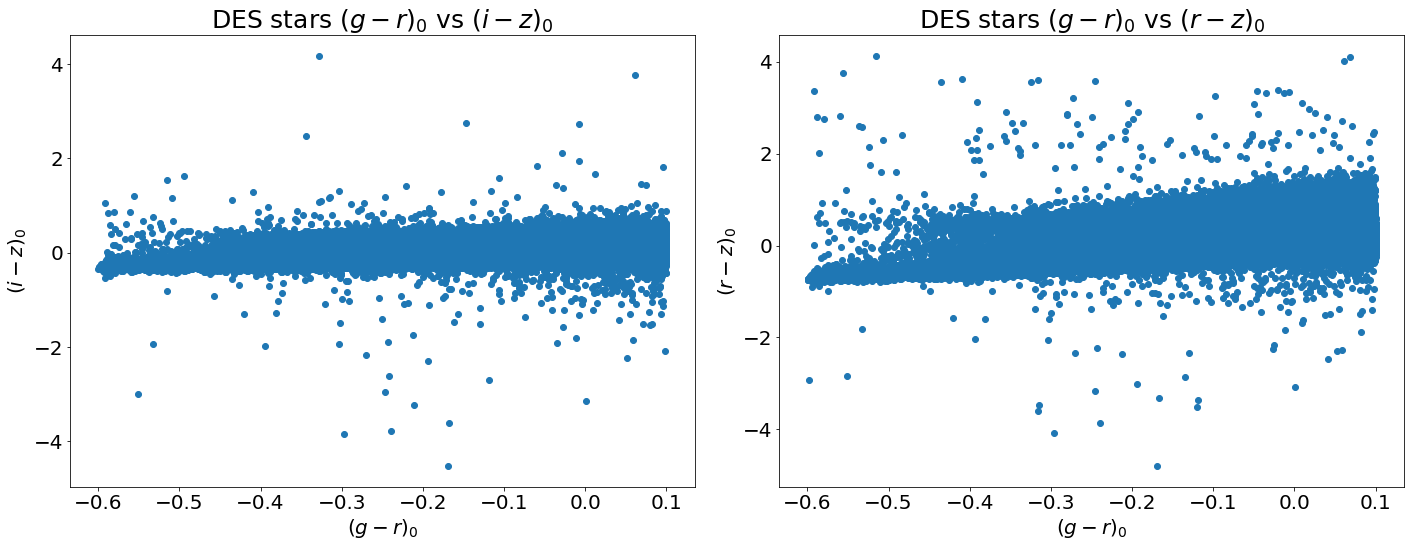

In [7]:
# visuals
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
plt.title(r"DES stars $(g-r)_0$ vs $(i-z)_0$")
plt.scatter(dataset['gr'], dataset['iz'])
plt.xlabel('$(g-r)_0$')
plt.ylabel('$(i-z)_0$')
plt.subplot(1,2,2)
plt.title(r"DES stars $(g-r)_0$ vs $(r-z)_0$")
plt.scatter(dataset['gr'], dataset['rz'])
plt.xlabel('$(g-r)_0$')
plt.ylabel('$(r-z)_0$')
plt.tight_layout()

In [8]:
# cut the data
cut = (betw(dataset["gr"], gr_min, gr_max))
data_cut = dataset[cut]

cut = betw(data_cut["rz"], rz_min, rz_max)
data_cut = data_cut[cut]

cut = betw(data_cut["iz"], iz_min, iz_max)
data_cut = data_cut[cut]

print(len(data_cut))

87432


### 1.2.3 Additional Cut on  $(g-r)_0 vs (r-z)_0$ to exclude objects that are likely WD or QSO.
This is necessary once we visualize the DES data in, for example, 18-20 mag in $(g-r)_0 vs (r-z)_0$ space.
$(r-z) > -0.17+(g-r)*0.9$

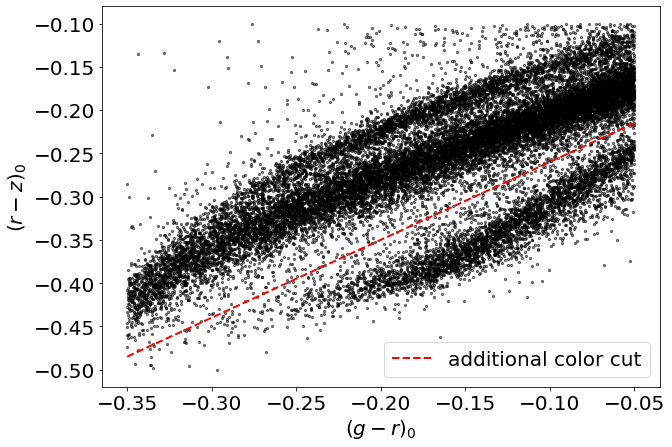

In [10]:
c1=extra_cut_coeff_1
c2=extra_cut_coeff_2
cut = betw(data_cut[g], 18, 20)
data_for_visual = data_cut[cut]
plt.figure(figsize=(10,7))
# plt.title(r'$g_0 = (18,20)$ mag')
x = data_for_visual['gr']
y = data_for_visual['rz']
plt.xlabel("$(g-r)_0$")
plt.ylabel("$(r-z)_0$")
xbounds = np.array([min(data_for_visual['gr']), max(data_for_visual['gr'])])
plt.plot(xbounds, c1 + c2 * xbounds, color='red', ls='--',linewidth=2,label='additional color cut')
plt.scatter(x, y, s=5,alpha=.5,c='k')
plt.legend()
plt.savefig( 'data_cut.pdf' , format='pdf', dpi=1000, bbox_inches='tight')
plt.show()

In [12]:
cut = data_cut['rz'] > extra_cut_coeff_1 + extra_cut_coeff_2 * data_cut['gr']
data_cut = data_cut[cut]
len(data_cut)

64059

### 1.2.4 Quality Cut

We only keep the objects that are highly-probable stars (extended_class_coadd <= 1), and with high-quality photometry (flags_g,r,i,z < 4)

In [13]:
data=data_cut
flag_num = 4
flag_cut = (data['flags_i'] < flag_num) & (data['flags_g'] < flag_num)  & (data['flags_r'] < flag_num) & (data['flags_z'] < flag_num)

star_cut = data['extended_class_coadd'] <= 1

cut = flag_cut & star_cut
data = data[cut]
print(len(data))
data_cut=data

60436


### 1.3.1 Calculate the error quadrature for g-r, r-z, i-z.

In [14]:
g_err,r_err,i_err,z_err = 'wavg_magerr_psf_g','wavg_magerr_psf_r','wavg_magerr_psf_i','wavg_magerr_psf_z'

# first calculate the uncertainty from dereddening
# since data are dereddened by subtracting constants, the measurement error will not change.

D = np.array([
    np.hypot(data_cut[g_err],data_cut[r_err]),
    np.hypot(data_cut[r_err],data_cut[z_err]),
    np.hypot(data_cut[i_err],data_cut[z_err])
])
column_gr = Column(name = "gr_err", data = D[0])
column_rz = Column(name = "rz_err", data = D[1])
column_iz = Column(name = "iz_err", data = D[2])
data_cut.add_columns([column_gr, column_rz, column_iz])




### 1.3.2 Plot the uncertainties as a function of $g_0$ magnitude
As we will see, the uncertainties for objects that are fainter than 21 mag are extremely high, so we will rmeove objects with $g_0 > 21$ mag.


In [15]:
# split the stars into different groups based on their magnitude
groups = np.linspace(16,22,13)
print(f'magnitude groups: {groups}')
splited_data=[]
for i in range(len(groups)-1):
    cut=betw(data_cut[g],groups[i],groups[i+1])
    splited_data.append(data_cut[cut])
    print(f'number of stars in group [{groups[i]}, {groups[i+1]}]: {len(splited_data[-1])}')
    

magnitude groups: [16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5 21.  21.5 22. ]
number of stars in group [16.0, 16.5]: 1727
number of stars in group [16.5, 17.0]: 1948
number of stars in group [17.0, 17.5]: 1999
number of stars in group [17.5, 18.0]: 2208
number of stars in group [18.0, 18.5]: 2520
number of stars in group [18.5, 19.0]: 3434
number of stars in group [19.0, 19.5]: 5754
number of stars in group [19.5, 20.0]: 6726
number of stars in group [20.0, 20.5]: 9835
number of stars in group [20.5, 21.0]: 9880
number of stars in group [21.0, 21.5]: 8277
number of stars in group [21.5, 22.0]: 4109


In [16]:
# Calculate mean errors and mean value of photometry in each magnitude group
means={'gr_mean':[], 'iz_mean':[], 'rz_mean':[],'g':[], 'r':[], 'i':[], 'z':[]}
mean_photometry = []
for l in range(len(splited_data)):
    
    gr_mean, iz_mean, rz_mean = np.mean(splited_data[l]['gr_err']), np.mean(splited_data[l]['iz_err']), np.mean(splited_data[l]['rz_err'])
    means['gr_mean'].append(gr_mean)
    means['iz_mean'].append(iz_mean)
    means['rz_mean'].append(rz_mean)
    
    mean_photometry.append(np.mean(splited_data[l][g]))

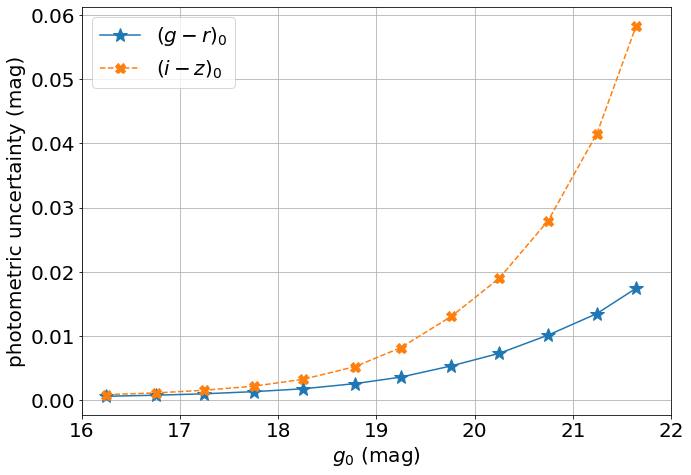

In [17]:
# title = r"Photometric Uncertainty in DES DR2"
plt.figure(figsize=(10,7))
plt.plot(mean_photometry, means['gr_mean'], label=r'$(g-r)_0$', marker='*', markersize=15)
plt.plot(mean_photometry, means['iz_mean'],'X--',label=r'$(i-z)_0$',markersize=10)
# plt.plot(mean_photometry, means['rz_mean'],label=r'$(r-z)_0$', marker='D', markersize=10)
plt.legend()

plt.ylabel(r'photometric uncertainty (mag)')
plt.xlabel(r'$g_0$ (mag)')
plt.grid(True)

plt.xlim(16,22)
plt.tight_layout()
plt.show()


In [18]:
# remove stars that are fainter than 21 mag
cut = betw(data_cut[g], min_g_mag, max_g_mag)
data_cut = data_cut[cut]
print(len(data_cut))

46031


### 1.4 Save the Data!

In [19]:
data_cut.write(saved_data_path, format = saved_format, overwrite=True)

These are the final objects we selected for modeling in the next step.


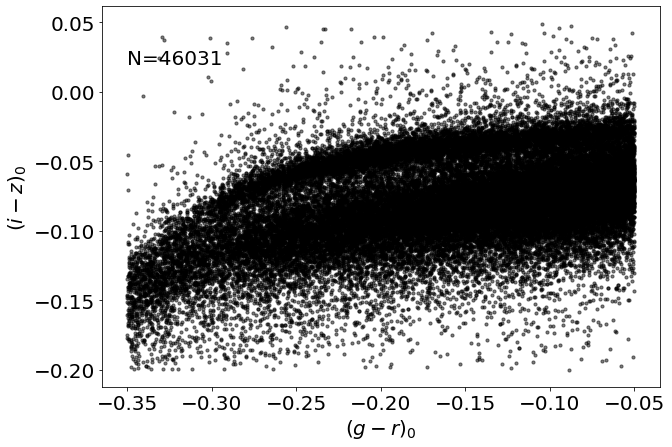

In [20]:
plt.figure(figsize=(10,7))
griz = np.array([data_cut['gr'], data_cut['iz']]).T
plt.scatter(griz[:, 0], griz[:, 1],c='k',alpha=.5,s=10)
plt.text(-0.35, 0.02, f'N={len(data_cut)}')
plt.xlabel('$(g-r)_0$')
plt.ylabel('$(i-z)_0$')
print('These are the final objects we selected for modeling in the next step.')

# Section 2. Hierarchical Bayesian Model

In this section, we build a mixture model, and then run Dynesty sampling to find the best-estimate of the parameters.
1. First we define a likelihood function of observing the data, given the some parameters of interests.
2. Then run dynesty to sample from the set of parameters that produces the models that well-fit our data.

In [32]:
from matplotlib import pyplot as plt

# plot figures within the notebook rather than externally
%matplotlib inline

import numpy as np
from numpy.polynomial import polynomial as P
import scipy
from scipy.special import logsumexp
from scipy.optimize import minimize
from astropy.io import fits
from astropy.table import Table, MaskedColumn, Column, vstack
from joblib import dump, load

plt.rcParams.update({'font.size': 20})
parameters = {'axes.labelsize': 20,
          'axes.titlesize': 25}
plt.rcParams.update(parameters)

## 2.1 Data

The input data should contain
1. photometries (eg. g, r, i, z band)
2. colors (eg. $(g-r)_0$ and $(i-z)_0$)
3. associated uncertainties in $(g-r)_0$ and $(i-z)_0$


In [33]:
########### Input Directories ############
# directories and files
input_HBC_path = os.path.join(root_dir,"processed_DES.fits") # input data for processing, assume '.fits' file

###########  Data  ############
# column names in the file
g_band,r_band,z_band,i_band = 'wavg_mag_psf_g_dered', 'wavg_mag_psf_r_dered', 'wavg_mag_psf_z_dered', 'wavg_mag_psf_i_dered' # column name for photometry bands
x_col_name, y_col_name = 'gr', 'iz' # the name of the column for colors
# (can also be other 2D pair, as long as you want to run mixture model on them)
x_err_name, y_err_name = 'gr_err', 'iz_err'# the name of the column that stores the uncertainties of photometry values (x,y)
# (can also be other 2D pair, as long as you want to run mixture model on them, should match the (x,y) pair)

BHB_min_g, BHB_max_g = 16,21 # g_0 (deredden) band magnitude for selecting BHB candidates

############ Notes #############
# input should be in '.fits' file

In [34]:
# Import the previously saved data for HBC modeling
data = Table.read(input_HBC_path, hdu=1).copy()
print(len(data))

46031


In [35]:
# initialize variables
griz = np.array([data[x_col_name], data[y_col_name]]).T # (g-r) and (i-z)
error = np.array([data[x_err_name], data[y_err_name]]).T # uncertainties
x, y = data[x_col_name], data[y_col_name] # (g-r), (i-z)
xe, ye = data[x_err_name], data[y_err_name]  # uncertainty in g-r, uncertainty in i-z
g = data[g_band] # g band

xmin, xmax = np.min(x), np.max(x) # min, max in (g-r)
ymin, ymax = np.min(y), np.max(y) # min, max in (i-z)



Text(0, 0.5, '$(i-z)_0$')

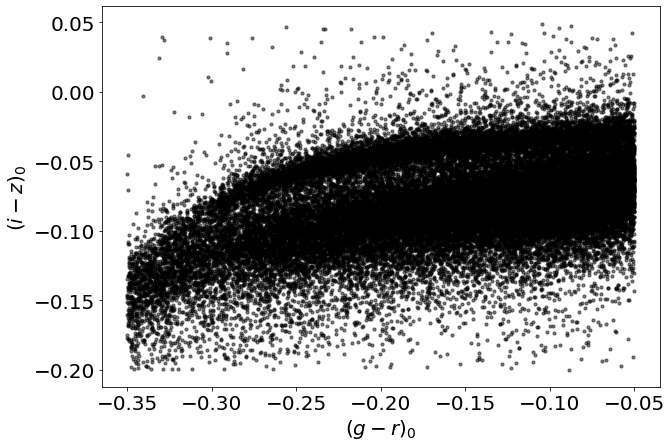

In [36]:
plt.figure(figsize=(10,7))
# plt.title(r"$r_0$=(16,21) mag")
plt.scatter(griz[:, 0], griz[:, 1],c='k',alpha=.5,s=10)
# plt.text(-0.1, -0.15, f'N={len(data)}', bbox=dict(fill=False, edgecolor='red', linewidth=2))
plt.xlabel('$(g-r)_0$')
plt.ylabel('$(i-z)_0$')

## 2.2  Model



### 2.2.1 Parameters of Interest
Parameters we are sampling:
1. BHB ridgeline coefficients, third order polynomial $a_3, a_2, a_1, a_0$
2. intrinsic scattering of BHBs $\sigma_{BHB}$
3. BS ridgeline coefficients, third order polynomial $b_3, b_2, b_1, b_0$
4. intrinsic scattering of BS $\sigma_{BS}$
5. background fraction, as a linear function of distance $c_1, c_0$
6. BHB fraction out of non-background stars, as a linear function of distance $d_1, d_0$


**In total 14 parameters**

In [37]:
######## Output Directories #########

saved_model_coeff = os.path.join(root_dir, 'mixture_model_coeff.npy') # directory to save the model coefficients
saved_data_path = os.path.join(root_dir, 'data_with_probability.fits') # directory to save the data with BHB probability calculated by the model and associated distances
saved_format = "fits" # data will be saved in '.fits' file


######## Mixture Model #########
# name of the parameters (here we have 14)
parameter_names = [r'$a_3$', r'$a_2$', r'$a_1$', r'$a_0$', r'$\sigma_{BHB}$',
             r'$b_3$', r'$b_2$', r'$b_1$', r'$b_0$', r'$\sigma_{BS}$',
             r'$c_1$', r'$c_0$',
             r'$d_1$', r'$d_0$'] 

# 2.output contains model coefficients, with the default order when you define the parameters for sampling.

### 2.2.2 The likelihood function

In [38]:
def compute_norm_logpdf(mu, var, x):
    """
    Return logpdf of the normal distribution with mean mu, 
    variance var, and measurement x.
    """
    
    chi2 = (mu - x) * (mu - x) / var
    lnorm = np.log(2. * np.pi * var)
    
    return -0.5 * (chi2 + lnorm)

def compute_log_likelihood_BHB_BS(theta, std_intrinsic, x, y, xerr, yerr, ngrid=50, sgrid=5.):
    """ 
    Return loglikelihood of points (x,y), assuming normal distribution
    given by mean (X, y(predicted by theta))) and variance yerr^2+std_intrinsic^2.
    """
    
    if np.all(np.isclose(xerr, 0.)):
        # noiseless-x case
        
        # evaluate polynomial to get true relation
        y_true = P.polyval(x, theta)
        
        # compute intrinsic scatter
        var = yerr * yerr + std_intrinsic * std_intrinsic
        
        # evaluate logpdf at the specified location
        lpdf = compute_norm_logpdf(y_true, var, y)
    else:
        # noisy-x case
        
        # evaluate polynomial over grid around measured values
        xgrid = x + np.linspace(-sgrid * xerr, sgrid * xerr, ngrid)  # (ngrid, ndata)
        y_true = P.polyval(xgrid, theta)
        
        # compute intrinsic scatter
        var = yerr * yerr + std_intrinsic * std_intrinsic
        
        # evaluate logpdf at specified locations
        lpdf_grid = compute_norm_logpdf(y_true, var, y)
        
        # average pdf over x grid
        wts = np.exp(-0.5 * np.linspace(-sgrid, sgrid, ngrid)**2)  # same wts for every point
        wgrid = np.repeat(wts, xgrid.shape[1]).reshape(xgrid.shape)  # weights
        lpdf = logsumexp(lpdf_grid, axis=0, b=wgrid)
    
    return lpdf

def noise_loglikelihood(xmax=xmax, xmin=xmin, ymax=ymax, ymin=ymin):
    """
    The likelihood function of noise. Assume conditional uniform distribution in y|x.
    """
    return -np.log(ymax - ymin)

def log_likelihood(BHB_theta, BS_theta, BHB_d, BS_d, f_BHB, f_BS, f_out, x, y, xerr, yerr):
    """
    Compute the loglikelihood function of all stars. 
    Defined by L(s|theta) = f(bhb)*L(bhb)+f(bs)*L(bs)+(1-f(bhb)-f(bs))*L(noise).
    Return an array for better computation using logsumexp.
    """
    
    # compute loglikelihood components
    L_BHB = compute_log_likelihood_BHB_BS(BHB_theta, BHB_d, x, y, xerr, yerr)
    L_BS = compute_log_likelihood_BHB_BS(BS_theta, BS_d, x, y, xerr, yerr)
    L_noise = np.full_like(L_BHB, noise_loglikelihood())
    
    # combine components
    weights = [f_BHB, f_BS, f_out]
    assert L_BHB.shape == f_BHB.shape
    assert L_noise.shape == f_out.shape
    L_comb = logsumexp([L_BHB, L_BS, L_noise], axis=0, b=weights)

    return L_comb


# the function to calculate the log likelihood function
def loglike(theta, x=x, y=y, xe=xe, ye=ye,g=g):
    """
    Log-likelihood as a function of parameters `theta`.
    BHB_theta, BHB_d = theta[:4], theta[4]
    BS_theta, BS_d = theta[5:9], theta[9]
    f_out = theta[10], fraction of outliers    
    """
    theta = theta / 100 # the theta values we obtained is 100x larger than the actual values
    # this is only because some parameters are extremely small, and I want to see the decimals more clearly
    # you may remove it to obtain the actual theta values
    
    # extract theta
    BHB_theta, BHB_d = theta[:4], theta[4]
    BS_theta, BS_d = theta[5:9], theta[9]
    
    # bound f_out
    f_out = P.polyval(g, theta[10:12])
    f_out = np.clip(f_out, 0, 0.4)
    
    # bound f_BHB
    f_BHB_in_non_out = P.polyval(g, theta[12:14])
    f_BHB_in_non_out = np.clip(f_BHB_in_non_out, 0, 1)
    
    f_BHB, f_BS = (1-f_out) * f_BHB_in_non_out, (1-f_out) * (1 - f_BHB_in_non_out)

    
    # BHB ridgeline must be above the BS ridgeline
    position_BHB = P.polyval(-0.2, BHB_theta)
    position_BS = P.polyval(-0.2, BS_theta)
    if position_BHB < position_BS:
        return float('-inf')
    
    # evaluate loglikelihoods
    logl = log_likelihood(BHB_theta=BHB_theta, BS_theta=BS_theta, 
                          BHB_d=BHB_d, BS_d=BS_d, 
                          f_BHB=f_BHB, f_BS=f_BS, f_out=f_out,
                          x=x, y=y, xerr=xe, yerr=ye)
    
    # compute total logL
    logl = np.sum(logl)
    
    return logl

### 2.2.3 Dynesty Sampling
You can find more info from https://dynesty.readthedocs.io/en/stable/

In [15]:
import dynesty
from schwimmbad import MultiPool

In addition to the function for loglikelihood, Dynesty also requires us to pass the prior distribution for the parameters.\
Here I will set the prior to be uniform distribution on some reasonable range.\
The range may vary for different parameters.


In [16]:
def prior_transform(u):
    """
    Prior transform that takes a point u ~ [0, 1] and transforms it
    to the prior distribution of interest (i.e. the inverse CDF).
    """
    # theta[:5]  BHB ridgeline coefficients, intrinsic scattering
    # theta[5:10]  BS ridgeline coefficients, intrinsic scattering
    # theta[10:12] background fraction, as a function of r
    # theta[12:14] BHB fraction out of non-background stars, as a function of r
    
    theta = np.copy(u)
    
    # BHB_theta (-s, s)
    lims = np.array([0.2, 1., 10., 25.])
    theta[:4] = (theta[:4] * lims * 2 - lims)*100
    
    # BHB_d (0, 0.015)
    theta[4] = theta[4] * 0.015 * 100
    
    # BS_theta (-s, s)
    theta[5:9] = (theta[5:9] * lims * 2 - lims) * 100
    
    # BS_d (0, 0.012)
    theta[9] = theta[9] * 0.015 * 100
    
    # f_out_theta (-s,s)
    lim = 3.5
    theta[10] = (theta[10] * lim * 2 - lim)*100
    lim = 0.6
    theta[11] = (theta[11] * lim * 2 - lim)*100
    
    # f_BHB_theta (-s,s)
    lim = 3.5
    theta[12] = (theta[12] * lim * 2 - lim)*100
    lim = 0.6
    theta[13] = (theta[13] * lim * 2 - lim)*100
       
    return theta


Now we can run the sampler!\
Notice here I used multi-core to speed up the process.

It may take several hours for the sampling process, if you think it's too slow you can change 'DynamicNestedSampler' to 'NestedSampler'\
It might affect the results a bit but hopefully not much

If you don't have access to a server with multiple CPU cores, you can also remove ``with MultiPool(nproc) as pool: `` and simply run the following:\
``sampler = dynesty.DynamicNestedSampler(loglike, prior_transform, 14)``\
``sampler.run_nested()``

In [11]:
# intialize sampler
nproc = 100
with MultiPool(nproc) as pool:
    sampler = dynesty.DynamicNestedSampler(loglike, prior_transform, 14, pool=pool) 
    # we pass the loglikelihood function, the prior, and # of parameters

    # run!
    sampler.run_nested()

    # print citations
    print(sampler.citations)
    


77139it [5:38:18,  3.80it/s, batch: 4 | bound: 50 | nc: 34 | ncall: 2797394 | eff(%):  2.758 | loglstar: 222554.852 < 222564.065 < 222561.471 | logz: 222431.604 +/-  0.401 | stop:  0.737]      

Code and Methods:
Speagle (2020): ui.adsabs.harvard.edu/abs/2020MNRAS.493.3132S
Koposov et al. (2022): doi.org/10.5281/zenodo.3348367

Nested Sampling:
Skilling (2004): ui.adsabs.harvard.edu/abs/2004AIPC..735..395S
Skilling (2006): projecteuclid.org/euclid.ba/1340370944
Dynamic Nested Sampling:
Higson et al. (2019): doi.org/10.1007/s11222-018-9844-0

Bounding Method:
Feroz, Hobson & Bridges (2009): ui.adsabs.harvard.edu/abs/2009MNRAS.398.1601F

Sampling Method:
Skilling (2006): projecteuclid.org/euclid.ba/1340370944



**Results**

In [12]:
# save results
dres = sampler.results

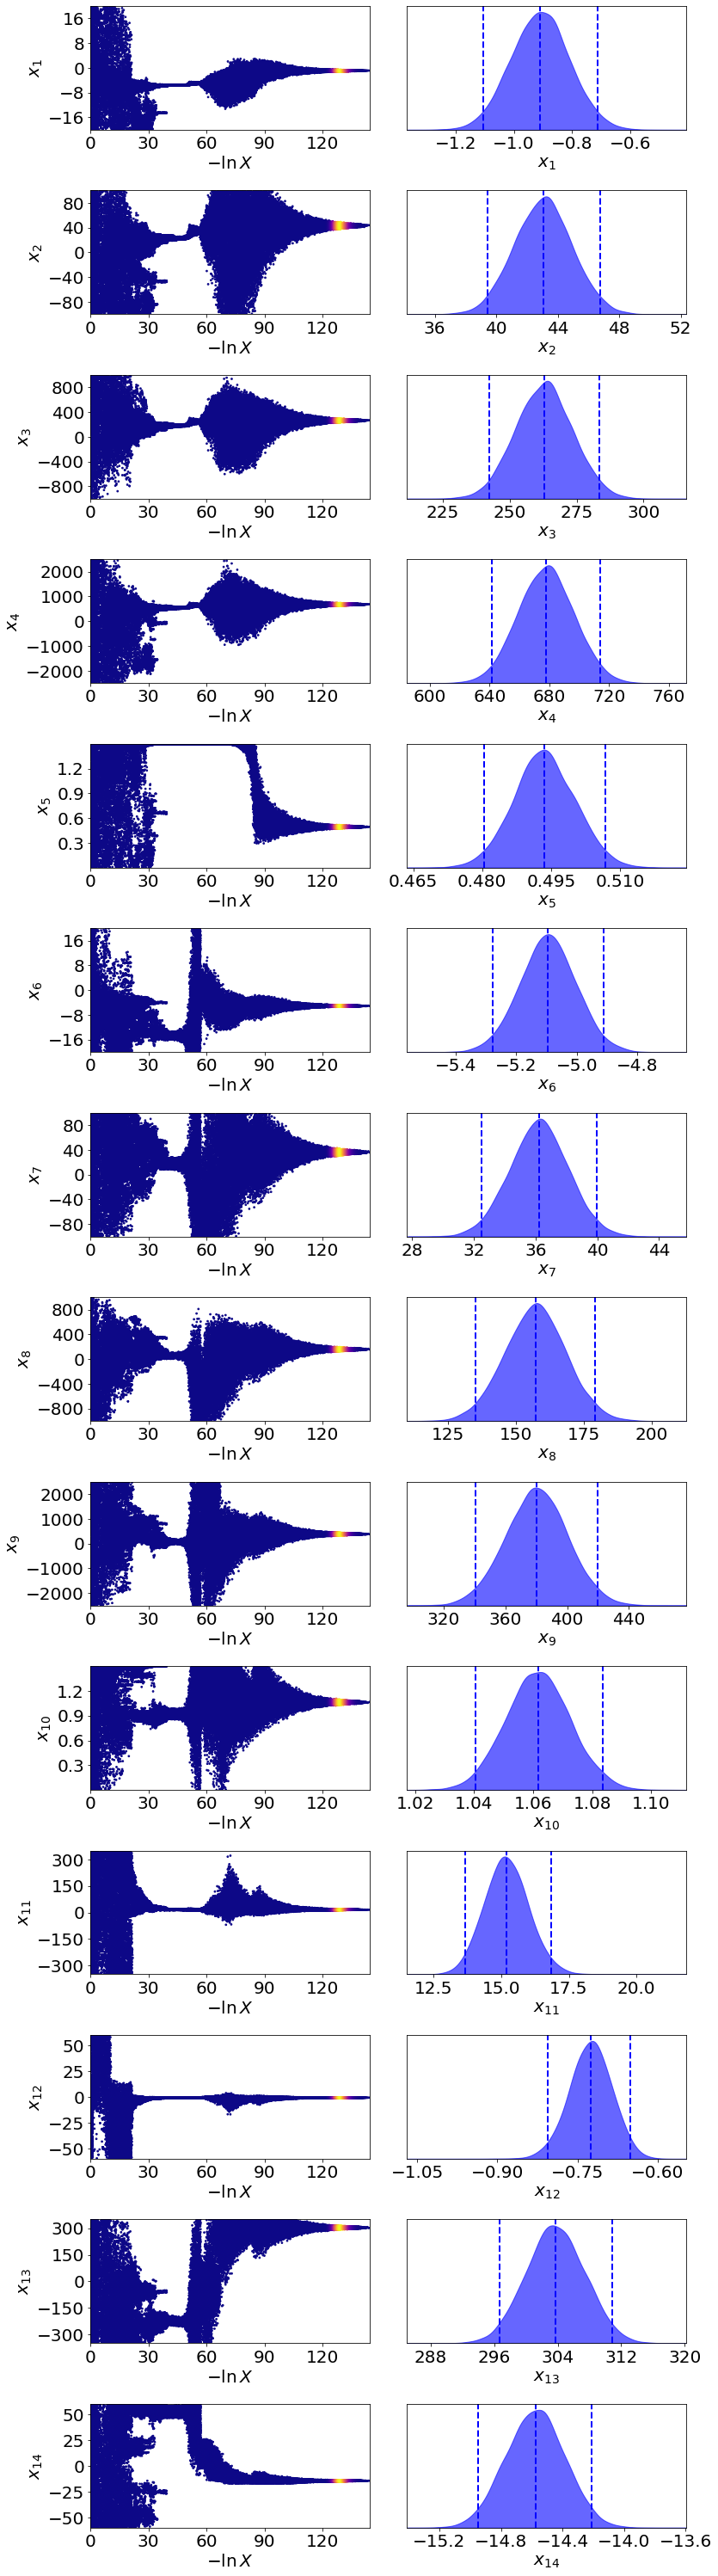

In [13]:
from dynesty import plotting as dyplot
from dynesty import utils as dyutils

# plot sampling progress over time
fig, ax = dyplot.traceplot(dres)
plt.tight_layout()

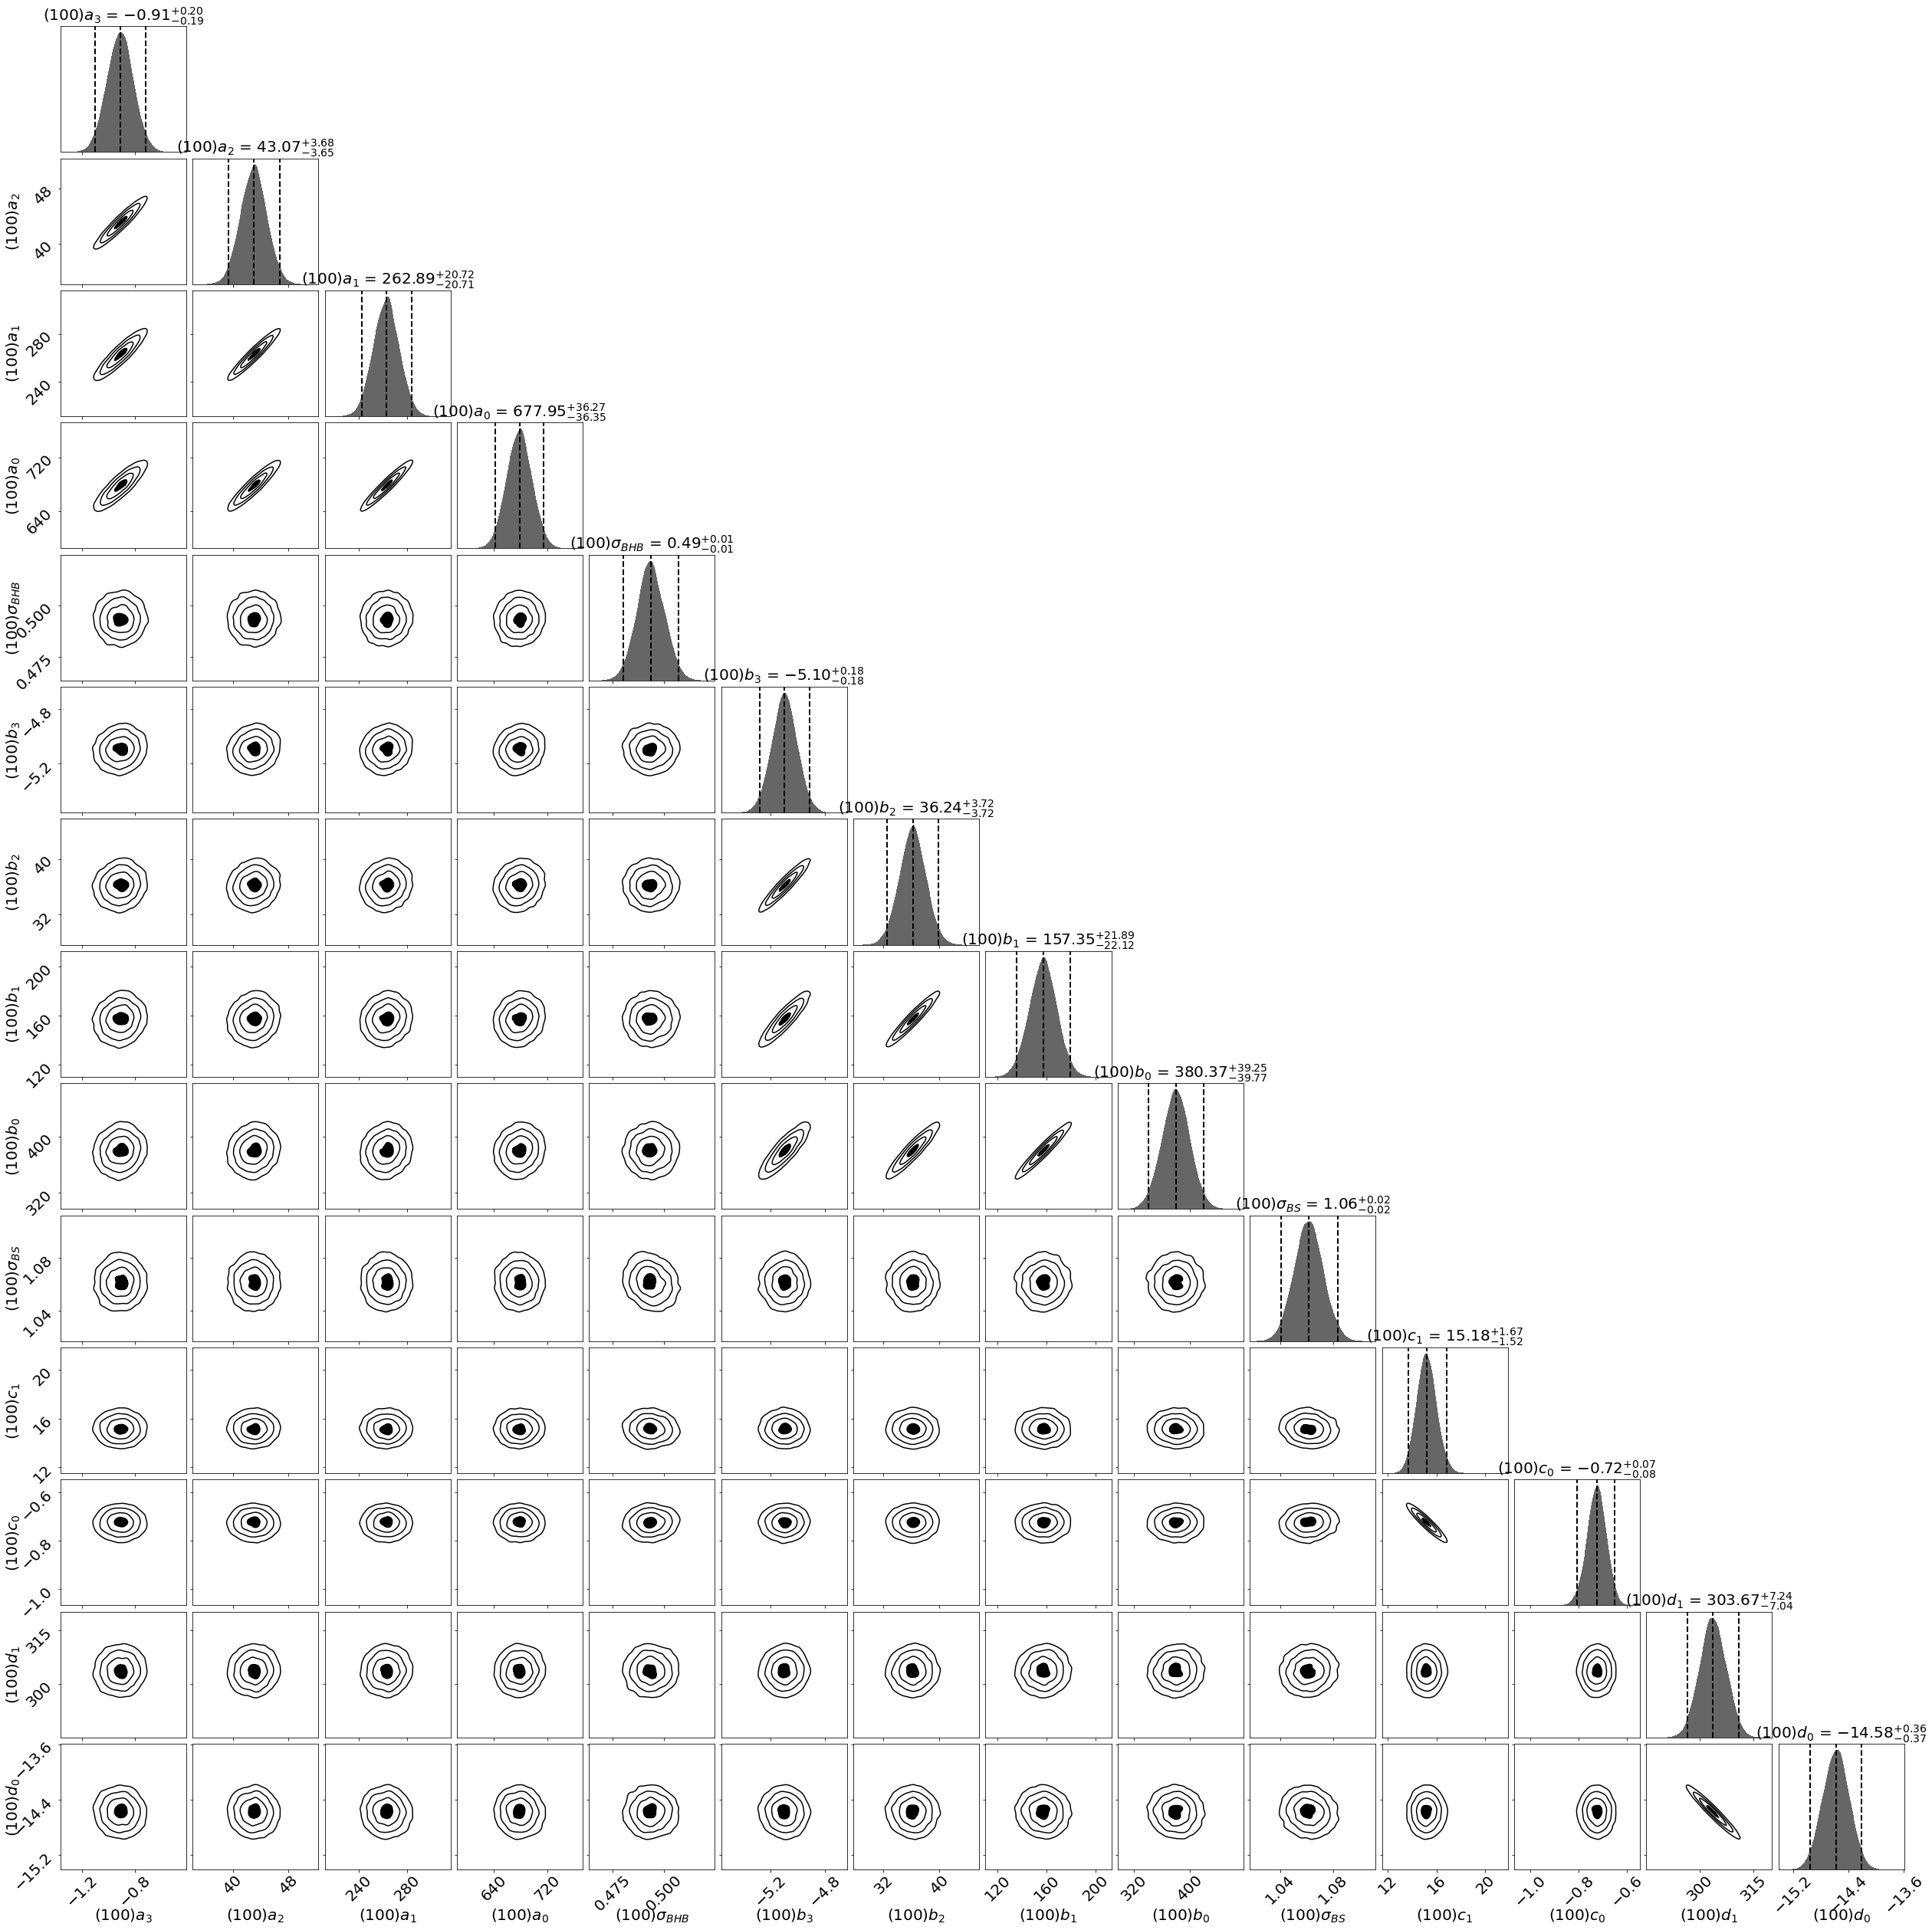

In [14]:
# generate corner plot

# change the scale
plt.rcParams.update({'font.size': 20})
parameters = {'axes.labelsize': 20,'axes.titlesize': 20,'xtick.major.pad':0,'axes.labelpad':100000}
plt.rcParams.update(parameters)
fig, axes = plt.subplots(14,14,figsize=(35,35))
spacing=240

# again, as I multiply the theta by 100, I will change the parameter names to make it clear
parameter_names = [r'$(100)a_3$', r'$(100)a_2$', r'$(100)a_1$', r'$(100)a_0$', r'$(100)\sigma_{BHB}$',
             r'$(100)b_3$', r'$(100)b_2$', r'$(100)b_1$', r'$(100)b_0$', r'$(100)\sigma_{BS}$',
             r'$(100)c_1$', r'$(100)c_0$',
             r'$(100)d_1$', r'$(100)d_0$']

# # 1 sigma
# title_quantiles=(0.16,0.5,0.84)
# 2 sigma, which is the default of Dynesty
title_quantiles=(0.025, 0.5, 0.975)

# plot
fig, ax = dyplot.cornerplot(dres, labels = parameter_names, max_n_ticks=3,show_titles=True, fig=(fig,axes), title_quantiles=title_quantiles)


**Best Sample**

In [20]:
# we grab the best sample
samp = dres.samples[-1] / 100 # divide by 100 to obtain the actual values
print(samp)
BHB_theta, BHB_d = samp[:4], samp[4]
BS_theta, BS_d = samp[5:9], samp[9]
f_out = samp[10:12]
f_BHB_prime = samp[12:14]

f_out = P.polyval(g, samp[10:12])
f_BHB_in_non_out = P.polyval(g, samp[12:14])

f_out = np.clip(f_out, 0, 0.4)
f_BHB_in_non_out = np.clip(f_BHB_in_non_out, 0, 1)

f_BHB, f_BS = (1-f_out) * f_BHB_in_non_out, (1-f_out) * (1 - f_BHB_in_non_out)

# print(f'Coefficients')
# print(f'f(BHB) = {f_BHB}, f(BS) = {f_BS}')
# print(f'theta(BHB) = {BHB_theta}, theta(BS) = {BS_theta}')
# print(f'dispersion(BHB) = {BHB_d}, dispersion(BS) = {BS_d}')

[-8.78734747e-03  4.38483918e-01  2.67925252e+00  6.87526831e+00
  4.94293021e-03 -5.12185043e-02  3.56991984e-01  1.53996737e+00
  3.73735811e+00  1.06613978e-02  1.49389090e-01 -7.13895885e-03
  3.02214532e+00 -1.44989847e-01]


## 2.3 Compute class probablities

Using the estimation of parameters, we can now compute the probabilites of each object being a BHB, BS, or outlier. 

In [40]:
# compute probabilities from the model
L_BHB = compute_log_likelihood_BHB_BS(BHB_theta, BHB_d, x, y, xe, ye)
L_BS = compute_log_likelihood_BHB_BS(BS_theta, BS_d, x, y, xe, ye)
L_noise = np.full_like(L_BHB, noise_loglikelihood())
L_comb = logsumexp([L_BHB, L_BS, L_noise], axis=0, 
                   b=[np.full_like(L_BHB, f_BHB), 
                      np.full_like(L_BS, f_BS), 
                      np.full_like(L_noise, f_out)])
p_ml = np.exp([L_BHB + np.log(f_BHB) - L_comb, 
               L_BS + np.log(f_BS) - L_comb, 
               L_noise + np.log(f_out) - L_comb])
p_ml = np.nan_to_num(p_ml)
print('# of classifications (ML) for BHB, BS, outliers:', np.nansum(p_ml, axis=1))

# of classifications (ML) for BHB, BS, outliers: [ 9475.96934451 36042.36124927   512.66940622]


/tmp/ipykernel_3807476/4004947913.py:9: RuntimeWarning: divide by zero encountered in log
  p_ml = np.exp([L_BHB + np.log(f_BHB) - L_comb,
/tmp/ipykernel_3807476/4004947913.py:11: RuntimeWarning: divide by zero encountered in log
  L_noise + np.log(f_out) - L_comb])


plot all these objects with their probablities

In [41]:
import matplotlib.colors as colors
class MidpointNormalize(colors.Normalize):
    """
    For BS, outliers.
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 0.9]
        return np.ma.masked_array(np.interp(value, x, y))
    
class MidpointNormalizeBHB(colors.Normalize):
    """
    For BHB.
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.3, 0.9]
        return np.ma.masked_array(np.interp(value, x, y))

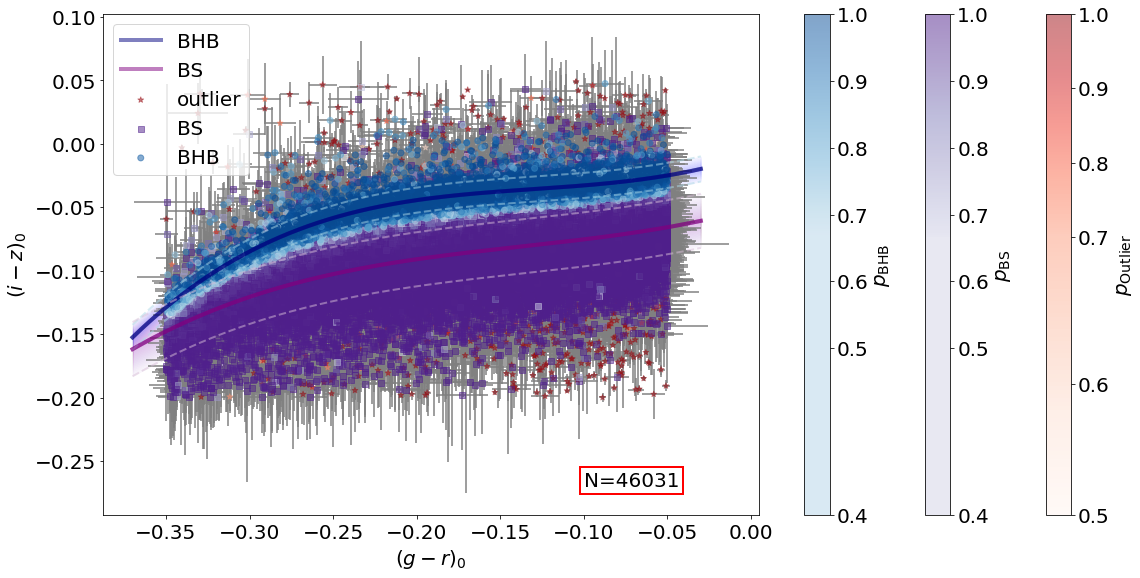

In [43]:

parameters = {'axes.labelsize': 20,'axes.titlesize': 25,'xtick.major.pad':5,'axes.labelpad':5}
plt.rcParams.update(parameters)

plt.figure(figsize=(16, 8),layout='constrained')
sorted_x = np.linspace(xmin - 0.02, xmax + 0.02, 1000)
alpha=.5
###################### Plot Ridgelines and Intrinsic Scattering ########################
# BHB and uncertainty estimates
plt.plot(sorted_x, P.polyval(sorted_x, BHB_theta), lw=4, alpha=0.5, color='navy', 
         label='BHB')  # plot BHB
[plt.fill_between(sorted_x, P.polyval(sorted_x, BHB_theta) + np.abs(BHB_d) * n, P.polyval(sorted_x, BHB_theta) - BHB_d * n, 
                  alpha=0.01, color='blue')
 for n in np.linspace(0, 2, 20)]  # plot BHB uncertainty estimates

# BS and uncertainty estimates
plt.plot(sorted_x, P.polyval(sorted_x, BS_theta), lw=4, alpha=0.5, color='purple', 
         label='BS')  # plot BS 
[plt.fill_between(sorted_x, P.polyval(sorted_x, BS_theta) + np.abs(BS_d) * n, P.polyval(sorted_x, BS_theta) - BS_d * n, 
                  alpha=0.01, color='darkviolet')
  for n in np.linspace(0, 2, 20)]  # plot BS uncertainty estimates

# dashes for the shading region
# Plot BHB solution
plt.plot(sorted_x, P.polyval(sorted_x, BHB_theta), lw=4, alpha=0.5, color='navy')
# Calculate BHB bounds and plot as dashed lines
upper_bound_bhb = P.polyval(sorted_x, BHB_theta) + np.abs(BHB_d) * 2
lower_bound_bhb = P.polyval(sorted_x, BHB_theta) - BHB_d * 2
plt.fill_between(sorted_x, upper_bound_bhb, lower_bound_bhb, alpha=0.01, color='blue')
plt.plot(sorted_x, upper_bound_bhb, '--',color='#ADD8E6',  alpha=0.5,lw=2)
plt.plot(sorted_x, lower_bound_bhb, '--',color='#ADD8E6', alpha=0.5,lw=2)

# Plot BS solution
plt.plot(sorted_x, P.polyval(sorted_x, BS_theta), lw=4, alpha=0.5, color='purple')
# Calculate BS bounds and plot as dashed lines
upper_bound_bs = P.polyval(sorted_x, BS_theta) + np.abs(BS_d) * 2
lower_bound_bs = P.polyval(sorted_x, BS_theta) - BS_d * 2
plt.fill_between(sorted_x, upper_bound_bs, lower_bound_bs, alpha=0.01, color='darkviolet')
plt.plot(sorted_x, upper_bound_bs, '--', color='#D8BFD8', alpha=0.5, lw=2)  # 'm' for magenta
plt.plot(sorted_x, lower_bound_bs,  '--', color='#D8BFD8',alpha=0.5,lw=2)

# plot errorbars underneath in grey
plt.errorbar(x, y, yerr=ye, xerr=xe, fmt='.', ms=0, 
             zorder=1, color='gray')


############################## Plot Star Probabilities ################################

# adjust size to proxy log-likelihood
sizes = 125 - 100 * (L_comb - L_comb.min()) / (L_comb.max() - L_comb.min())

# For each object, we classify it to be the category with highest probabilities
# outlier group
sel_out = np.argmax(p_ml, axis=0) == 2
plt.scatter(x[sel_out], y[sel_out], c=p_ml[2][sel_out], 
            cmap='Reds', norm=MidpointNormalize(midpoint=0.7), 
            marker='*', label="outlier",alpha=alpha)
plt.colorbar(label=r"$p_\mathrm{Outlier}$")

# BS gorup
sel_BS = np.argmax(p_ml, axis=0) == 1
plt.scatter(x[sel_BS], y[sel_BS], c=p_ml[1][sel_BS], 
            cmap='Purples', norm=MidpointNormalizeBHB(midpoint=0.5), 
            marker='s', label="BS",alpha=alpha)
plt.colorbar(label=r"$p_\mathrm{BS}$")

# BHB group
sel_BHB = np.argmax(p_ml, axis=0) == 0
plt.scatter(x[sel_BHB], y[sel_BHB], c=p_ml[0][sel_BHB], 
            cmap='Blues', norm=MidpointNormalizeBHB(midpoint=0.5), 
            marker='o', label="BHB",alpha=alpha)
plt.colorbar(label=r"$p_\mathrm{BHB}$")


# prettify plot
plt.xlabel('$(g-r)_0$')
plt.ylabel('$(i-z)_0$')
# plt.title('Population/Mixture Model')
plt.text(-0.1, -0.27, f'N={len(data)}', bbox=dict(fill=False, edgecolor='red', linewidth=2))
plt.legend()

We can also check how the fraction of each category changes with respect to magnitude

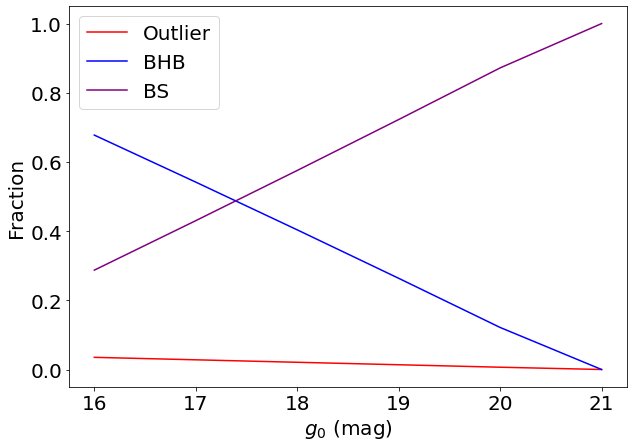

In [19]:
BHB_theta, BHB_d = samp[:4], samp[4]
BS_theta, BS_d = samp[5:9], samp[9]
f_out = samp[10:12]
f_BHB_prime = samp[12:14]

mag_range=[16,17,18, 19, 20, 21]
f_out = P.polyval(mag_range, f_out)
f_out = np.clip(f_out, 0, 0.4)
f_BHB_prime = P.polyval(mag_range,f_BHB_prime)
f_BHB_prime = np.clip(f_BHB_prime, 0, 1)
f_BHB, f_BS = (1 - f_out) * f_BHB_prime, (1 - f_out) * (1 - f_BHB_prime)
plt.figure(figsize=(10,7))
plt.plot(mag_range,f_out, label="Outlier",c='r')
plt.plot(mag_range,f_BHB, label="BHB",c='b')
plt.plot(mag_range,f_BS, label="BS",c='purple')
plt.ylabel('Fraction')
plt.xlabel(r'$g_0$ (mag)')
plt.legend()


Save the results!

In [20]:
# save the objects with their probabilities
t1 = Column(name='p_ml_BHB', data=p_ml[0])
data.add_column(t1)
t1 = Column(name='p_ml_BS', data=p_ml[1])
data.add_column(t1)
t1 = Column(name='p_ml_outlier', data=p_ml[2])
data.add_column(t1)
data.write(saved_data_path, format = saved_format, overwrite=True)

# save the model coefficients
with open(saved_model_coeff, 'wb') as f:
    np.save(f, samp)